# Model Loading

In [1]:
import os
os.chdir('../')
import glob
import cv2
import random
import numpy as np
from PIL import Image

%pip install onnxruntime-gpu -Uq
import onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reading the model
model_path = 'models/exp1_yolov8m/best.onnx'
EP_LIST = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = onnxruntime.InferenceSession(model_path, providers=EP_LIST)
ort_session

In [3]:
# Getting the input data from the model
model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_names, input_shape

(['images'], [1, 3, 640, 640])

In [4]:
# Getting the output data from the model
model_outputs = ort_session.get_outputs()
output_names = [model_outputs[i].name for i in range(len(model_inputs))]
output_shape = model_outputs[0].shape
output_names, output_shape

(['output0'], [1, 5, 8400])

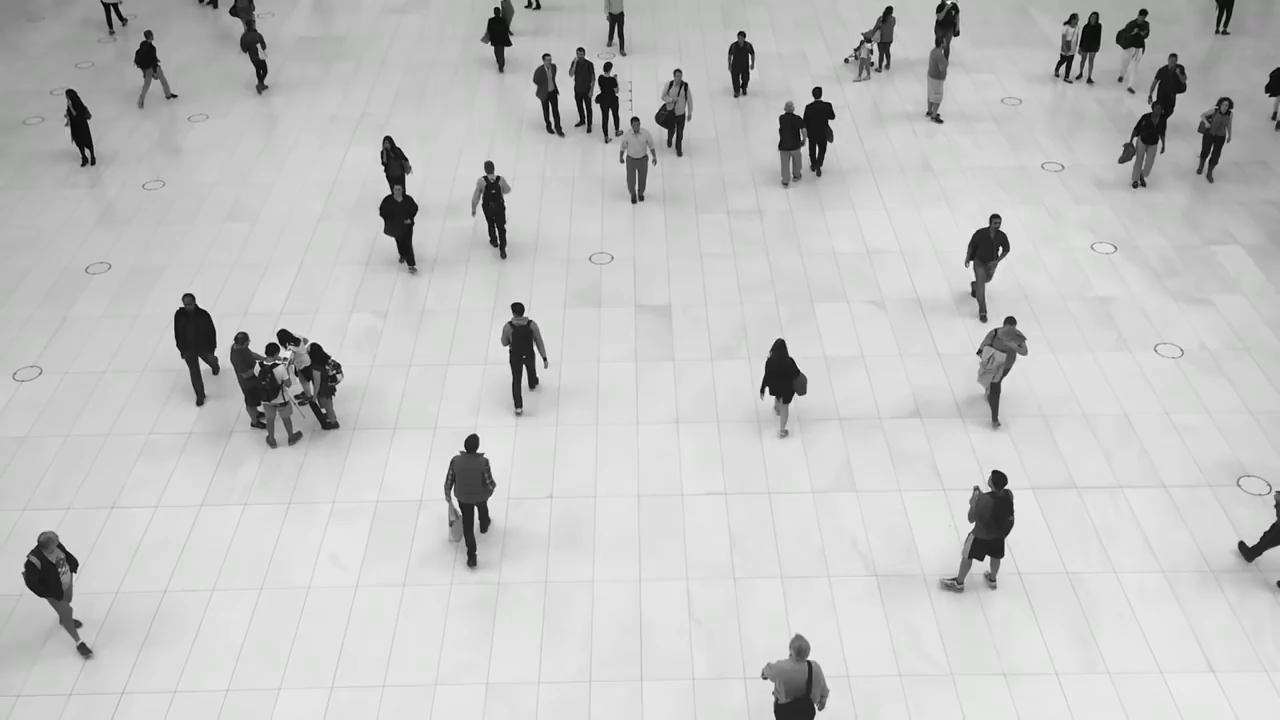

In [5]:
# Getting a image for testing
#img_filename = random.sample(glob.glob('datasets/images/val/*'), 1)[0]
video_reader = cv2.VideoCapture('Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4')
_, image = video_reader.read()
image_height, image_width = image.shape[:2]
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
# Transforming the image as per the model inputs preprocess
input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (input_width, input_height))

# Normalizing the image array
input_image = image_resized / 255.
input_image = input_image.transpose(2, 0, 1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)

In [7]:
# Running inference on the image
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]
outputs, outputs.shape

(array([[[3.5419459e+00, 1.0377311e+01, 1.6315601e+01, ...,
          5.5029065e+02, 5.7983563e+02, 6.2461676e+02],
         [1.2875952e+01, 1.2133954e+01, 9.2605276e+00, ...,
          6.1570807e+02, 6.1917834e+02, 6.2443451e+02],
         [6.6977711e+00, 1.8543200e+01, 2.1784721e+01, ...,
          1.1928351e+02, 1.0217456e+02, 3.4265259e+01],
         [2.5695927e+01, 2.4255758e+01, 1.8538233e+01, ...,
          7.9408447e+01, 6.2668030e+01, 3.4513916e+01],
         [8.3446503e-07, 0.0000000e+00, 3.5762787e-07, ...,
          4.7683716e-07, 5.9604645e-07, 5.1259995e-06]]], dtype=float32),
 (1, 5, 8400))

In [8]:
# Transposing the output
predictions = np.squeeze(outputs).T

# Filtering the prediction on a threshold
conf_thresh = 0.5
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresh, :]
scores = scores[scores > conf_thresh]

# Getting class ids with the highest confidence scores
class_id = np.argmax(predictions[:, 4:], axis=1)

predictions, scores, class_id

(array([[5.6650948e+01, 1.6908852e+01, 3.1537533e+01, 3.3802124e+01,
         7.9837507e-01],
        [5.6639702e+01, 1.6883133e+01, 3.1830158e+01, 3.3751785e+01,
         7.8721142e-01],
        [2.6447855e+02, 4.6217332e+00, 2.5801224e+01, 9.2377615e+00,
         5.7200509e-01],
        ...,
        [3.9816733e+02, 5.9979822e+02, 4.4114624e+01, 8.0085815e+01,
         8.0122578e-01],
        [3.9807224e+02, 6.0000885e+02, 4.4258362e+01, 7.9835205e+01,
         8.2638097e-01],
        [3.9808002e+02, 5.9994275e+02, 4.4277405e+01, 8.0034546e+01,
         8.1360209e-01]], dtype=float32),
 array([0.79837507, 0.7872114 , 0.5720051 , 0.68358123, 0.61753017,
        0.64916223, 0.8602061 , 0.85898757, 0.8562002 , 0.7754445 ,
        0.7845231 , 0.7537353 , 0.72700244, 0.7137687 , 0.71311677,
        0.864707  , 0.860572  , 0.855581  , 0.7846379 , 0.78923875,
        0.82940716, 0.8360708 , 0.7597776 , 0.7468724 , 0.82500476,
        0.8095333 , 0.85978556, 0.85120946, 0.83604693, 0.7673283 

In [9]:
# Getting the bounding box for all the predictions
boxes = predictions[:, :4]

# Rescaling the boxes to the original image size
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes, boxes.shape

(array([[113,  19,  63,  38],
        [113,  18,  63,  37],
        [528,   5,  51,  10],
        ...,
        [796, 674,  88,  90],
        [796, 675,  88,  89],
        [796, 674,  88,  90]], dtype=int32),
 (343, 4))

In [10]:
# Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
def xywh2xyxy(x):
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y
boxes = xywh2xyxy(boxes)
boxes, boxes.shape

(array([[ 81,   0, 144,  38],
        [ 81,   0, 144,  36],
        [502,   0, 553,  10],
        ...,
        [752, 629, 840, 719],
        [752, 630, 840, 719],
        [752, 629, 840, 719]], dtype=int32),
 (343, 4))

In [11]:
# Performing Non maximum suppression using IoU
def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for all the boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])
    
    # Compute intersection area
    intersection_area = np.maximum(0, xmax-xmin) * np.maximum(0, ymax-ymin)
    
    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area
    
    # Iou
    iou = intersection_area / union_area
    return iou

def nms(boxes, scores, iou_threshold):
    # Sorting the scores descending
    sorted_indices = np.argsort(scores)[::-1]
    
    # Looping through the boxes
    keep_boxes = []
    while sorted_indices.size > 0:
        # Picking the highest score box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)
        
        # Compute IoU of picked box with the rest of the boxes
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])
        
        # Removing boxes that are higher than threshold
        keep_indices = np.where(ious < iou_threshold)[0]
        
        # Filtering the sorted indices on keep indices
        sorted_indices = sorted_indices[keep_indices + 1]
        
    return keep_boxes

indices = nms(boxes, scores, 0.5)
len(indices)

40

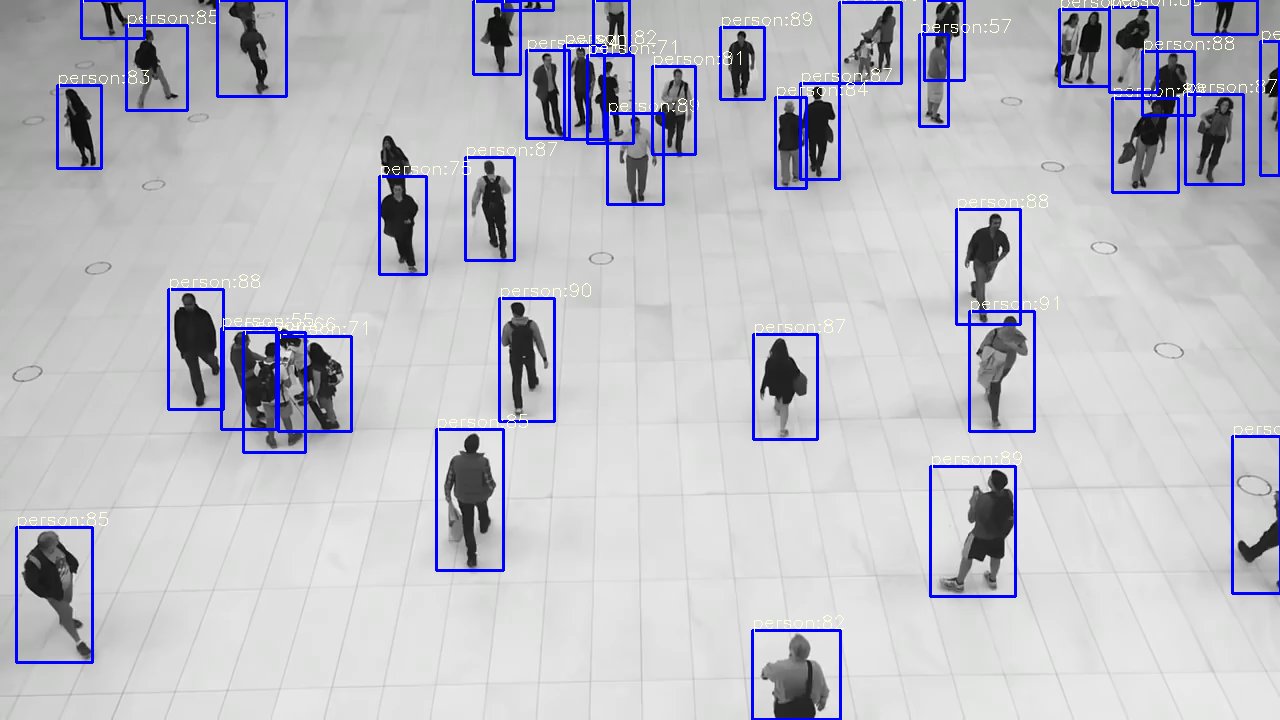

In [12]:
CLASSES = ['person']
image_draw = image.copy()
for (bbox, score, label) in zip(boxes[indices], scores[indices], class_id[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = CLASSES[cls_id]
    color = (255, 0, 0)
    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(image_draw,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)
Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

# Model Loading - Modular

## Creating Utility file - utils.py

In [13]:
%%writefile module/utils.py
import numpy as np
import cv2

# Rescale any bounding box
def rescale_boxes(boxes, input_shape, output_shape):
    """
    This functions helps in re-scaling bounding box from one object to another.
    
    Parameters:
        boxes: An array containing the values of the bounding box.
        input_shape: A tuple or list containing values of the original object shape. E.g. (height, width)
        output_shape: A tuple or list containing values of the output object shape. E.g. (height, width)
    
    Returns:
        boxes: An array containing the values of the rescale boxes.
    """
    input_shape = np.array([input_shape[1], input_shape[0], input_shape[1], input_shape[0]])
    boxes = np.divide(boxes, input_shape, dtype=np.float32)
    boxes *= np.array([output_shape[1], output_shape[0], output_shape[1], output_shape[0]])
    return boxes

# Convert bounding box from YOLO format (x_c, y_c, w, h) into Pascal VOC format (x1, y1, x2, y2)
def bbox_yolo_to_pascal(boxes):
    """
    This function helps in converting the bounding box format from YOLO to Pascal VOC.
    
    Parameters:
        boxes: An array containing the values of the bounding box in YOLO format.
    
    Returns:
        boxes_cp: An array containing the values of the bounding box in Pascal VOC format.
    """
    boxes_cp = boxes.copy()
    boxes_cp[..., 0] = boxes[..., 0] - boxes[..., 2] / 2
    boxes_cp[..., 1] = boxes[..., 1] - boxes[..., 3] / 2
    boxes_cp[..., 2] = boxes[..., 0] + boxes[..., 2] / 2
    boxes_cp[..., 3] = boxes[..., 1] + boxes[..., 3] / 2
    return boxes_cp

# Clipping the bounding box values
def clip_bbox(boxes, height, width):
    """
    This function helps in clipping the values of the bounding box.
    
    Parameters:
        boxes: An array containing the values of the bounding box. 
        height: An int value of the height of a Image or Frame.
        width: An int value of the width of a Image or Frame.
    
    Return:
        clip_boxes: An array containing the clipped values of the bounding box.
    """
    clip_boxes = boxes.copy()
    clip_boxes[..., 0] = np.clip(boxes[..., 0], 0, width)
    clip_boxes[..., 1] = np.clip(boxes[..., 1], 0, height)
    clip_boxes[..., 2] = np.clip(boxes[..., 2], 0, width)
    clip_boxes[..., 3] = np.clip(boxes[..., 3], 0, height)
    return clip_boxes

# Computing the Intersection over Union of the bounding box.
def compute_iou(box, boxes):
    """
    This function helps in calculating the intersection over union of the bounding boxes.
    This function best works with prediction result, where one predicted box is computed with 
    multiple different predicted boxes.
    
    Parameters:
        box: An array containing values of a bounding box.
        boxes: An array containing values of multiple different bounding box.
    
    Returns:
        iou: An array containing iou values in between range (0, 1) for all the boxes array.
    """
    # Getting the intersection box
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])
    
    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)
    
    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area
    
    # Compute IoU
    iou = intersection_area / union_area
    return iou

# Computing Non Maximum Suppression on all the bounding box
def compute_nms(boxes, scores, iou_threshold):
    """
    This function helps in computing the Non Maximum Suppression on the 
    predicted bounding boxes.
    
    Parameters:
        boxes: An array containing the values of the bounding boxes.
        scores: An array containing the values of the confidence scores
                for each bounding box.
        iou_threshold: A float value to suppress the bounding box.
                       Value should be within the range (0, 1).
    
    Returns: 
        Keep_boxes: A list containing the index for the boxes and scores 
                    array after computing Non Maximum Suppression.
    """
    # Getting the list of indices of sorted scores - descending order
    sorted_indices = np.argsort(scores)[::-1]
    
    # Looping through the indices and computing nms
    keep_boxes = []
    while sorted_indices.size > 0:
        # Picking the box with best score
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)
        
        # Compute IoU of the picked box with rest of the boxes
        ious = compute_iou(box=boxes[box_id, :], boxes=boxes[sorted_indices[1:], :])
        
        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]
        
        # Keeping only the indices that fit within the threshold
        sorted_indices = sorted_indices[keep_indices + 1]
        
    return keep_boxes

def draw_detections(image, boxes, scores, class_ids, class_list):
    """
    This function helps in drawing the predicted detection bounding box on the image.
    
    Parameters:
        image: An array containing the values of the base image in RGB format.
        boxes: An array containing the values of the predicted bounding box in Pascal Voc format.
        scores: An array containing the values of the confidence score for each predicted bounding box.
        class_ids: An array containing the values of the predicted classes indices. 
        class_list: A list containing all the class names in proper order.

    Returns:
        image: An array containing the values for the image with the predicted bounding box drawn for every object.
    """
    image_height, image_width = image.shape[:2]
    size = min([image_height, image_width]) * 0.001 # Dynamic fontscale
    text_thickness = int(min([image_height, image_width]) * 0.001) # Dynamic thickness
    
    # Generating colors for every class
    rng = np.random.default_rng(3) # Random number generator
    colors = rng.uniform(0, 255, size=(len(class_list), 3))
    
    # Draw predicted bounding box and labels on the image
    for box, score, class_id in zip(boxes, scores, class_ids):
        color = colors[class_id]
        x1, y1, x2, y2 = box.astype(int)
        
        # Drawing rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Getting the box coords of the label text
        label = class_list[class_id]
        caption = f'{label} {int(score * 100)}%'
        (tw, th), _ = cv2.getTextSize(text=caption, 
                                      fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                                      fontScale=size, 
                                      thickness=text_thickness)
        th = int(th * 1.2)
        
        # Drawing rectangle for the text
        cv2.rectangle(image, 
                      (x1, y1), 
                      (x1 + tw, y1 - th if y1 - 10 > 0 else y1 + 10 + th), 
                      color, 
                      -1)
        
        # Adding the label text
        cv2.putText(image, 
                    caption, 
                    (x1, y1 if y1 - 10 > 0 else y1 + 15), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    size, 
                    (255, 255, 255), 
                    text_thickness)
    return image

Overwriting module/utils.py


In [14]:
%%writefile module/model_engine.py
import math
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
from utils import rescale_boxes, bbox_yolo_to_pascal, clip_bbox, compute_nms, draw_detections

class YoloDetectPredict:
    """
    This class helps in loading the model, predicting objects in the image and providing bounding
    box coords for all the detected objects in the image.
    Parameters:
        model_path: A string to the path directing towards the model location.
        conf_threshold: A float in the range (0, 1) for thresholding the confidence scores.
        iou_threshold: A float in the range (0, 1) for thresholding IoU while Non maximum supression.
    """
    def __init__(self, model_path, conf_threshold = 0.7, iou_threshold = 0.5):
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        
        # Initializing the model
        self.initialize_model(model_path)
        
    def initialize_model(self, model_path):
        # Initializing onnx model instance
        EP_LIST = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        self.ort_session = onnxruntime.InferenceSession(model_path, 
                                                        providers = EP_LIST)
        # Get meta data from the model
        self.get_meta_details()
        self.get_input_details()
        self.get_output_details()
        
    def get_meta_details(self):
        # Getting the model meta data.
        model_meta = self.ort_session.get_modelmeta()
        self.class_dict = eval(model_meta.custom_metadata_map['names'])
        self.class_list = list(self.class_dict.values())
        return self.class_list
    
    def get_input_details(self):
        # Getting the input data
        model_inputs = self.ort_session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]
        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]
    
    def get_output_details(self):
        # Getting the output data
        model_outputs = self.ort_session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]
        
    def __call__(self, image):
        # Performing prediction on the image
        return self.detect_objects(image)
    
    def detect_objects(self, image):
        # Prepare the image array as a input tensor.
        input_tensor, self.input_img_resized = self.prepare_input(image)
        
        # Perform inference on the image
        outputs = self.inference(input_tensor)
        
        # Extract prediction data
        self.boxes, self.scores, self.class_ids = self.process_output(outputs)
        
        return self.boxes, self.scores, self.class_ids
    
    def prepare_input(self, image):
        # Getting image info
        self.image_height, self.image_width = image.shape[:2]
        
        # Resize input image to input size
        input_img_resized = cv2.resize(image, (self.input_width, self.input_height))
        
        # Preprocessing the input image
        input_img = input_img_resized / 255.0 # Normalizing
        input_img = input_img.transpose(2, 0, 1) # Converting the image into CHW format
        input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32) # Batching
        
        return input_tensor, input_img_resized
    
    def inference(self, input_tensor):
        # Predicting using the Yolo onnx model
        outputs = self.ort_session.run(self.output_names, {self.input_names[0]: input_tensor})
        
        return outputs
    
    def process_output(self, output):
        # Extracting predictions from box outputs
        predictions = np.squeeze(output).T # Transposing the data into (prediction, features)
        
        # Filter out on confidence scores below threshold
        scores = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[scores > self.conf_threshold, :]
        scores = scores[scores > self.conf_threshold]
        
        # Validating for no prediction
        if len(scores) == 0:
            return [], [], []
        
        # Getting class with the highest confidense score
        class_ids = np.argmax(predictions[:, 4:], axis=1)
        
        # Getting the bounding box for all the objects
        boxes = self.extract_boxes(predictions)
        
        # Apply Non Maximum Supression(NMS) to suppress overlapping box
        indices = compute_nms(boxes=boxes, 
                              scores=scores, 
                              iou_threshold=self.iou_threshold)
        return boxes[indices], scores[indices], class_ids[indices]
    
    def extract_boxes(self, predictions):
        # Extract box from predictions
        boxes = predictions[:, :4]
        
        # Scale boxes to original image dimension
        boxes = rescale_boxes(boxes=boxes, 
                              input_shape=(self.input_height, self.input_width), 
                              output_shape=(self.image_height, self.image_width))
        
        # Convert the boxes to pascal voc format
        boxes = bbox_yolo_to_pascal(boxes=boxes)
        
        # Clipping the boxes range to a image limit
        boxes = clip_bbox(boxes=boxes, 
                          height=self.image_height, 
                          width=self.image_width)
        
        return boxes
    
    def draw_bbox(self, image):
        # Drawing the predicted bounding box.
        return draw_detections(image=image,
                               boxes=self.boxes,
                               scores=self.scores,
                               class_ids=self.class_ids,
                               class_list=self.class_list)

Overwriting module/model_engine.py


## Testing the Modular Code

In [15]:
os.chdir('module')
from model_engine import YoloDetectPredict

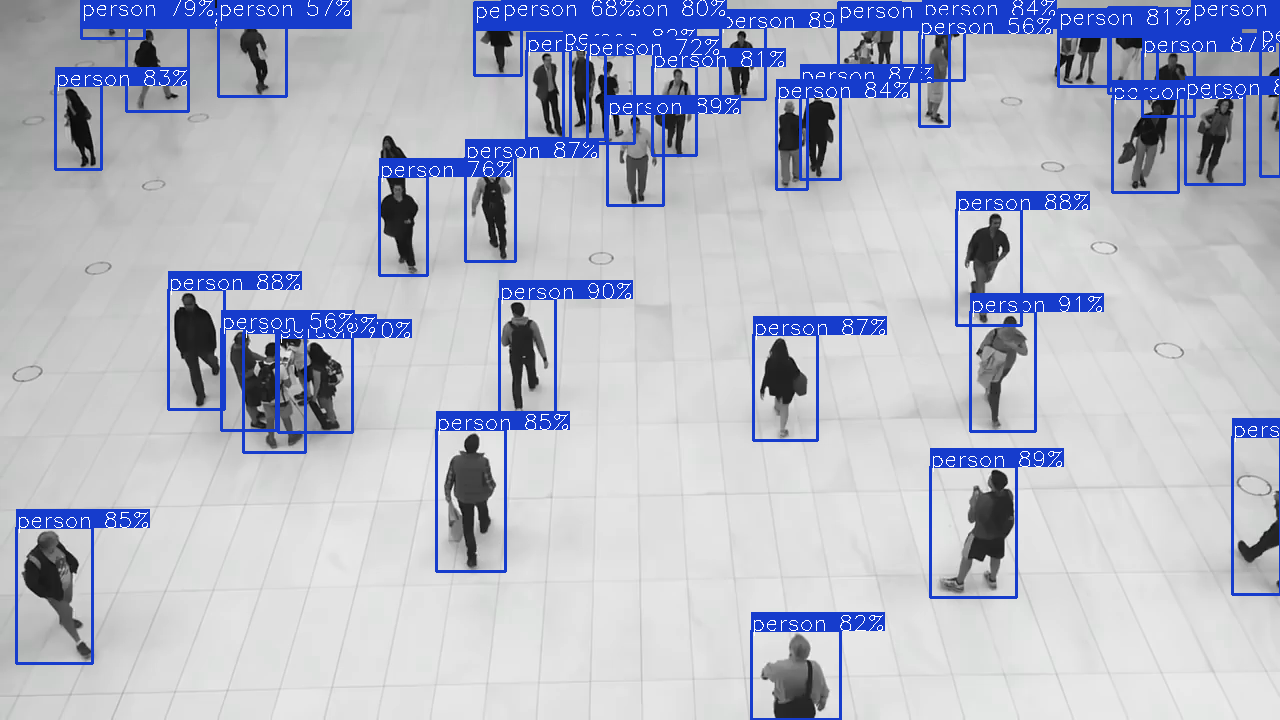

In [23]:
# Getting image data
video_reader = cv2.VideoCapture('../Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4')
_, image = video_reader.read()
image_height, image_width = image.shape[:2]

# Predicting using the onnx model
model_path = '../models/exp1_yolov8m/best.onnx'

# Loading the model instance
model = YoloDetectPredict(model_path=model_path, conf_threshold=0.5, iou_threshold=0.5)

# Getting the prediction for the image
boxes, scores, class_ids = model(image)
classes = model.get_meta_details()

# drawing the 
Image.fromarray(model.draw_bbox(image=image))